In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch_geometric as pyg
import networkx as nx
from model.MinAggGNN import MinAggGNN

seed = 0
torch.manual_seed(seed)
rng = np.random.default_rng(seed)

device = torch.device('cuda')
K = 2
m = 2

model = MinAggGNN(2, 8, K, 2, edge_dim = 1)
model.to(device)

MinAggGNN(2, 2, num_layers=2)

In [2]:
train = torch.load('data/training_data.pt')
test = torch.load('data/test_data.pt')

for data in train:
    data.x = torch.cat([data.x, data.x_bfs], 1)

for data in test:
    data.x = torch.cat([data.x, data.x_bfs], 1)

train_loader = pyg.loader.DataLoader(train, batch_size = len(train))
num_reachable_nodes = sum([data.reachable.sum() for data in train])
total_nodes = sum([data.num_nodes for data in train])
test_loader = pyg.loader.DataLoader(test, batch_size = len(test))
num_reachable_test_nodes = sum([data.reachable.sum() for data in test])

weight = torch.tensor((total_nodes - num_reachable_nodes) / num_reachable_nodes, device=device)

C:\Users\heje197\AppData\Local\Temp\ipykernel_18196\4194720481.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weight = torch.tensor((total_nodes - num_reachable_nodes) / num_reachable_nodes, device=device)


In [3]:
from tqdm import tqdm
from model.CustomLosses import MultiplicativeLoss

dst_criterion = torch.nn.MSELoss()
bfs_criterion = torch.nn.BCEWithLogitsLoss(pos_weight=weight)
test_criterion = MultiplicativeLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.001)
epochs = 20000
eta = 0.001
alpha = 1.0
beta = 50.0

def training():
    model.train()
    for data in train_loader:
        data.to(device)
        out = model(data.x, data.edge_index, edge_attr = data.edge_attr, batch = data.batch)
        mse_loss = dst_criterion(out[:,0].flatten()[data.reachable], data.y[data.reachable])
        mse_loss /= num_reachable_nodes
        bce_loss = bfs_criterion(out[:,1].flatten(), data.reachable.float())
        bce_loss /= data.num_nodes
        l1_regularization = torch.tensor(0., device=device)
        for param in model.parameters():
            l1_regularization += param.abs().sum()
        total_loss = alpha * mse_loss + beta * bce_loss + eta * l1_regularization
        total_loss.backward()
        optimizer.step()

        bfs_acc = ((out[:,1].flatten() > 0) == data.reachable).sum().item() / data.num_nodes
    return mse_loss, bce_loss, bfs_acc, l1_regularization, total_loss

def testing():
    torch.no_grad()
    model.eval()
    test_loss = torch.tensor(0.)
    bfs_acc = torch.tensor(0.)
    for data in test_loader:
        data.to(device)
        out = model(data.x, data.edge_index, edge_attr = data.edge_attr, batch = data.batch)
        test_loss += test_criterion(out[:,0].flatten()[data.reachable], data.y[data.reachable]).cpu()
        bfs_acc += ((out[:,1].flatten() > 0) == data.reachable).sum().item()
    test_loss /= num_reachable_test_nodes
    bfs_acc /= data.num_nodes
    return test_loss.detach().cpu(), bfs_acc.detach().cpu()

mse_losses = torch.zeros(epochs)
train_accs = torch.zeros(epochs)
l1_regs = torch.zeros(epochs)
test_losses = torch.zeros(epochs)
test_accs = torch.zeros(epochs)
model_checkpoints = []

pbar = tqdm(range(epochs))
for epoch in pbar:
    optimizer.zero_grad()
    mse_loss, bce_loss, train_acc, l1_reg, total_loss = training()
    mse_losses[epoch] = mse_loss
    train_accs[epoch] = train_acc
    l1_regs[epoch] = l1_reg
    test_loss, test_acc = testing()
    test_losses[epoch] = test_loss
    test_accs[epoch] = test_acc
    if epoch % 100 == 0:
        model_checkpoints.append({k: v.cpu() for k, v in model.state_dict().items()})
    pbar.set_description(f'Train MSE: {float(mse_loss):.4f}, Train BCE: {float(beta * bce_loss):.4f}, Train Acc: {float(train_acc):.4f}, L1 Reg: {float(l1_reg):.4f}, Test Loss: {float(test_loss):.4f}, Test Acc: {float(test_acc):.4f}')
model.eval()

  0%|          | 0/20000 [00:00<?, ?it/s]c:\Users\heje197\AppData\Local\miniconda3\envs\stargazer\Lib\site-packages\torch_geometric\warnings.py:11: UserWarning: The usage of `scatter(reduce='min')` can be accelerated via the 'torch-scatter' package, but it was not found
  warnings.warn(message)
Train MSE: 0.0002, Train BCE: 0.0024, Train Acc: 0.9927, L1 Reg: 23.6830, Test Loss: 0.0741, Test Acc: 0.9956: 100%|██████████| 20000/20000 [29:25<00:00, 11.33it/s]  


MinAggGNN(2, 2, num_layers=2)

In [4]:
torch.save(model.state_dict(), 'model_progress/simultaneous/model_final.pt')
torch.save(model_checkpoints, 'model_progress/simultaneous/model_checkpoints.pt')
torch.save(mse_losses, 'model_progress/simultaneous/mse_losses.pt')
torch.save(train_accs, 'model_progress/simultaneous/train_accs.pt')
torch.save(l1_regs, 'model_progress/simultaneous/l1_regs.pt')
torch.save(test_losses, 'model_progress/simultaneous/test_losses.pt')
torch.save(test_accs, 'model_progress/simultaneous/test_accs.pt')

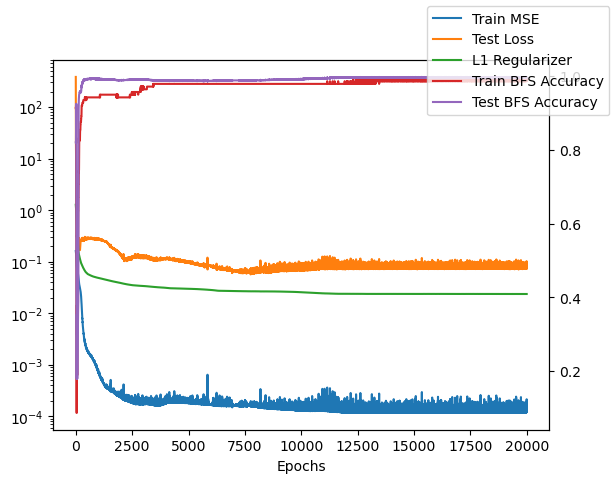

In [5]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(mse_losses.detach(), label='Train MSE')
ax.plot(test_losses.detach(), label='Test Loss')
ax.plot((eta * l1_regs).detach(), label='L1 Regularizer')

ax2 = ax.twinx()
ax2.plot(train_accs.detach(), label='Train BFS Accuracy', color='tab:red')
ax2.plot(test_accs.detach(), label='Test BFS Accuracy', color='tab:purple')

ax.set_yscale('log')
ax.set_xlabel('Epochs')
fig.legend()

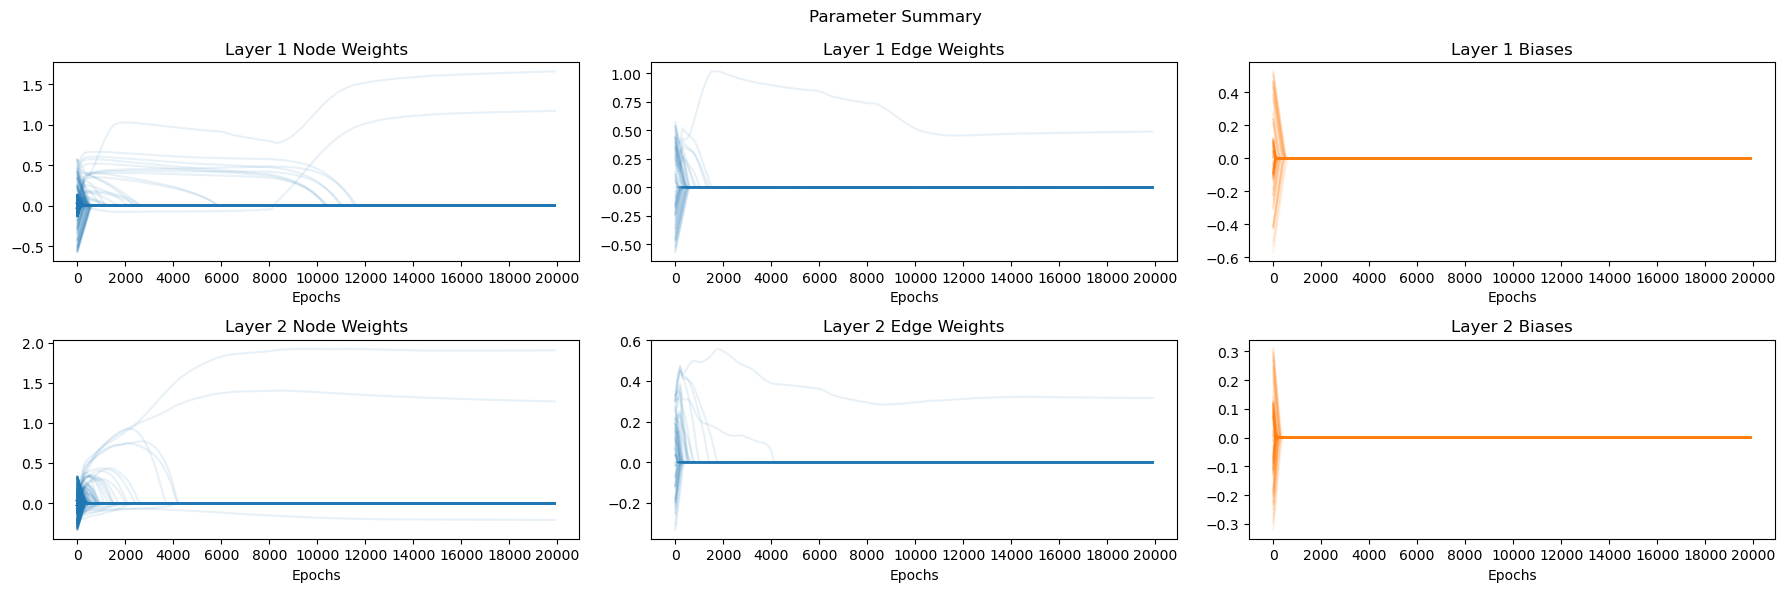

In [6]:
node_weights_0 = torch.empty((len(model_checkpoints),
                         len(model.state_dict()['convs.0.agg_mlp.lins.0.weight'][:,:-1].flatten())
                         + len(model.state_dict()['convs.0.agg_mlp.lins.1.weight'][:,:-1].flatten())
                         ))
node_weights_1 = torch.empty((len(model_checkpoints),
                         len(model.state_dict()['convs.1.agg_mlp.lins.0.weight'][:,:-1].flatten())
                         + len(model.state_dict()['convs.1.agg_mlp.lins.1.weight'][:,:-1].flatten())
                         ))
edge_weights_0 = torch.empty((len(model_checkpoints),
                         len(model.state_dict()['convs.0.agg_mlp.lins.0.weight'][:,-1].flatten())
                         ))
edge_weights_1 = torch.empty((len(model_checkpoints),
                         len(model.state_dict()['convs.1.agg_mlp.lins.0.weight'][:,-1].flatten())
                         ))
biases_0 = torch.empty((len(model_checkpoints),
                         len(model.state_dict()['convs.0.agg_mlp.lins.0.bias'].flatten())
                         + len(model.state_dict()['convs.0.agg_mlp.lins.1.bias'].flatten())
                         ))
biases_1 = torch.empty((len(model_checkpoints),
                         len(model.state_dict()['convs.1.agg_mlp.lins.0.bias'].flatten())
                         + len(model.state_dict()['convs.1.agg_mlp.lins.1.bias'].flatten())
                         ))
for i, checkpoint in enumerate(model_checkpoints):
    node_weights_0[i] = torch.cat((checkpoint['convs.0.agg_mlp.lins.0.weight'][:,:-1].flatten(),
                              checkpoint['convs.0.agg_mlp.lins.1.weight'][:,:-1].flatten()))
    node_weights_1[i] = torch.cat((checkpoint['convs.1.agg_mlp.lins.0.weight'][:,:-1].flatten(),
                              checkpoint['convs.1.agg_mlp.lins.1.weight'][:,:-1].flatten()))
    edge_weights_0[i] = checkpoint['convs.0.agg_mlp.lins.0.weight'][:,-1].flatten()
    edge_weights_1[i] = checkpoint['convs.1.agg_mlp.lins.0.weight'][:,-1].flatten()
    biases_0[i] = torch.cat((checkpoint['convs.0.agg_mlp.lins.0.bias'].flatten(),
                              checkpoint['convs.0.agg_mlp.lins.1.bias'].flatten()))
    biases_1[i] = torch.cat((checkpoint['convs.1.agg_mlp.lins.0.bias'].flatten(),
                              checkpoint['convs.1.agg_mlp.lins.1.bias'].flatten()))
    
fig, ax = plt.subplots(2,3, figsize = (18,6))

n_ticks = 5
ax[0,0].set_title('Layer 1 Node Weights')
ax[0,0].plot(node_weights_0.detach(), c = 'tab:blue', alpha = 0.1)

ax[0,1].set_title('Layer 1 Edge Weights')
ax[0,1].plot(edge_weights_0.detach(), c = 'tab:blue', alpha = 0.1)

ax[0,2].set_title('Layer 1 Biases')
ax[0,2].plot(biases_0.detach(), c = 'tab:orange', alpha = 0.1)

ax[1,0].set_title('Layer 2 Node Weights')
ax[1,0].plot(node_weights_1.detach(), c = 'tab:blue', alpha = 0.1)

ax[1,1].set_title('Layer 2 Edge Weights')
ax[1,1].plot(edge_weights_1.detach(), c = 'tab:blue', alpha = 0.1)

ax[1,2].set_title('Layer 2 Biases')
ax[1,2].plot(biases_1.detach(), c = 'tab:orange', alpha = 0.1)

for axes in ax.flatten():
    axes.set_xticks(range(0, len(model_checkpoints)+1, len(model_checkpoints) // 10))
    axes.set_xticklabels(range(0, epochs+1, epochs // 10))
    axes.set_xlabel('Epochs')

fig.suptitle('Parameter Summary')
fig.tight_layout()